In [1]:
import ast
import json
import csv
import mapbox
import urllib
import gmplot
import requests
import numpy as np
import geopandas as gpd
from shapely import geometry
from shapely.geometry import Point
from csv import reader
from mapbox import Geocoder
from flask import Flask, request, render_template
from math import radians, degrees, sin, cos, asin, acos, sqrt
from pyproj import Proj

In [11]:
MAPBOX_ACCESS_KEY = 'pk.eyJ1IjoidGxldWNiIiwiYSI6ImNrN2N3d3h1aTA0YWwzaHFoNGJreDJmY2YifQ.pbWSn9txb4n8fKmUaKAG4g'

In [12]:
def great_circle(lat1, lon1, lat2, lon2):
	"""
	This function calculates the shortest distance between two sets of coordinates.
	"""

	lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

	# use 6371 if calculating kilometers (3958.756 for miles)
	return 3958.756 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))

In [13]:
def read_csv():
	"""
	This function reads the polygon csv file and returns the coordinates to create the polygon in mapbox
	to be displayed in the html file.
	"""

	# setting up list
	lat_input = []
	lon_input = []

	# read CSV file but skipped header line in read
	with open('static/polygon.csv', 'r') as read_line:
	    csv_reader = reader(read_line)
	    header = next(csv_reader)
	    # Check file as empty
	    if header != None:
	        # Iterate over each row after the header in the csv
	        for row in csv_reader:
	        	lat_input.append(ast.literal_eval(row[1]))
	        	lon_input.append(ast.literal_eval(row[0]))

	map_output = [[a, b] for a, b in zip(lon_input, lat_input)]

	return map_output

In [14]:
def convert_point(lat,lon):
    """
    Convert Coordinate Reference systems from map lat/lon to fire raster CRS
    Input: Point of latitude,longitude
    Output: Tuple of (x,y) in CRS coordinates
    """

    # Declare point (longitude (or x) always comes first, then latitude (y))
    point = Point(lon,lat)
    
    # Set Source CRS (Mapbox or Google Maps)
    src_crs = "EPSG:4326"
    
    # create dataframe from input lat/long
    gdf=gpd.GeoDataFrame(index=[0],crs = src_crs, geometry=[point])
        
    # Change CRS to match Wildfire CRS (3857)
    gdf_tf = gdf.to_crs("epsg:3857")
    
    # pull x and y value out from the POINT attribute, then get
    # the value in the data series at row[0]
    x = gdf_tf.geometry.x.at[0]
    y = gdf_tf.geometry.y.at[0]
        
    return (x,y)

In [15]:
def convert_polygon(fire_polygon):
    """Convert Coord ref system (CRS) from fire data (EPSG 3857) to map 
    lat/long (EPSG 4326), polygon starts and ends on same point (to close it)
    
    Input: list containing tuples of x,y points in fire CRS that describe a polygon
    Output: list containing tuples of lat/long points that describe the polygon
    """
    
    # create polygon
    poly = geometry.Polygon([(p[0], p[1]) for p in fire_polygon])
    
    #CRS
    src_crs = "EPSG:3857"
    dst_crs = "EPSG:4326"
    
    # Create Geo DataFrame
    gfp = gpd.GeoDataFrame(index=[0],crs=src_crs,geometry=[poly])
    
    # Convert CRS
    gfp2 = gfp.to_crs(dst_crs)
    
    # pull data from dataframe
    polyout = gfp2.iloc[0]['geometry']
    
    # create list of tuples, but longitude is first
    l = list(map(tuple,np.asarray(polyout.exterior.coords)))
    l = list(map(lambda m: (m[1],m[0]), l))
    
    return l

In [16]:
def get_lat_loc(address):
	"""
	Convert a string of address to latitude and longitude 
	Input: String 
	Output: latitude, longitude coordinate
	"""

	geocoder = mapbox.Geocoder(access_token = MAPBOX_ACCESS_KEY)
	response = geocoder.forward(address)
	address = response.json()
	add_lat = address["features"][0]["center"][1]
	add_lon = address["features"][0]["center"][0]
	return add_lat, add_lon

In [17]:
def points(poly):
    return list(map(tuple,np.asarray(poly.exterior.coords)))

In [18]:
def active_fire(lat_origin, lon_origin):
	"""
	Function to find coordinates of active fires of given origin
	Input: latitude, longitude of input address (origin)
	Output: List of active fires within certain miles of origin
	"""

	# set variables
	lat_geo = []
	lon_geo = []
	geo_center = []

	url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
	# geo_data = requests.get(url).json()	
	geo_data = gpd.read_file(url)

	poly_list = geo_data.geometry

	for i in range(0,len(poly_list)):

		if len(geo_center) > 0:
			break

		if poly_list[i].geom_type == 'MultiPolygon':

			for j in range(0, len(poly_list[i])):

				geo_poly = points(poly_list[i][j])

				for k in range(0, len(geo_poly)):

					fire_lon = geo_poly[k][0]
					fire_lat = geo_poly[k][1]

					dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

					if dist <= 100:
						geo_center = [fire_lon, fire_lat]
						break

				if len(geo_center) > 0:
					break

			if len(geo_center) > 0:
				break

		else:

			geo_poly = points(poly_list[i])

			for j in range(0, len(geo_poly)):

				fire_lon = geo_poly[j][0]
				fire_lat = geo_poly[j][1]

				dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

				if dist <= 100:
					geo_center = [fire_lon, fire_lat]
					break

			if len(geo_center) > 0:
				break

		if len(geo_center) > 0:
			break

	return geo_center, geo_poly

In [23]:
def active_fire(lat_origin, lon_origin):
	"""
	Function to find coordinates of active fires of given origin
	Input: latitude, longitude of input address (origin)
	Output: List of active fires within certain miles of origin
	"""

	# set variables
	lat_geo = []
	lon_geo = []
	geo_center = []

	# # read JSON on active fire
	# url = 'https://www.fire.ca.gov/umbraco/api/IncidentApi/List?inactive=true'
	# geo_data = requests.get(url).json()

	# # loop through list provided by Cal Fire and find active fire within certain miles of origin
	# for i in range(0,len(geo_data)):
	#     if geo_data[i]['IsActive'] == "Y":
	#         fire_lat = geo_data[i]['Latitude']
	#         fire_lon = geo_data[i]['Longitude']
	#         dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)
	#         if dist <= 100:
	#         	lat_geo.append(fire_lat)
	#         	lon_geo.append(fire_lon)

	# geo_center = [[a, b] for a, b in zip(lon_geo, lat_geo)]

	# geo_center = [[-121.9230432, 36.52439536]]

	# return geo_center

	# read JSON on active fire
	url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
	# geo_data = requests.get(url).json()	
	geo_data = gpd.read_file(url)

	poly_list = geo_data.geometry

	for i in range(0,len(poly_list)):

		if poly_list[i].geom_type == 'MultiPolygon':

			for j in range(0, len(poly_list[i])):

				geo_poly = points(poly_list[i][j])

				for k in range(0, len(geo_poly)):

					fire_lon = geo_poly[k][0]
					fire_lat = geo_poly[k][1]

					dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

					if dist <= 100:
						geo_center = [fire_lon, fire_lat]
						break

				if len(geo_center) > 0:
					break

			if len(geo_center) > 0:
				break

		else:

			geo_poly = points(poly_list[i])

			for j in range(0, len(geo_poly)):

				fire_lon = geo_poly[j][0]
				fire_lat = geo_poly[j][1]

				dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

				if dist <= 100:
					geo_center = [fire_lon, fire_lat]
					break

			if dist <= 100:
				geo_center = [fire_lon, fire_lat]
				break

		if len(geo_center) > 0:
			break

	return geo_center, geo_poly

In [19]:
geo_center = active_fire(36.543286, -121.929533)

In [20]:
geo_center

([],
 [(-87.3723336319999, 34.213034613),
  (-87.372306366, 34.2132703290001),
  (-87.3725622159999, 34.213410965),
  (-87.372279828, 34.213694565),
  (-87.372152733, 34.213824523),
  (-87.3719566949999, 34.214390687),
  (-87.371732303, 34.2149686920001),
  (-87.371649312, 34.2154519650001),
  (-87.3719062, 34.215804636),
  (-87.373603407, 34.214750887),
  (-87.3750598079999, 34.2137685590001),
  (-87.374520687, 34.21371134),
  (-87.374151684, 34.2136535160001),
  (-87.3740940929999, 34.213453412),
  (-87.3739654399999, 34.213229928),
  (-87.373567669, 34.213066214),
  (-87.373113302, 34.2129497810001),
  (-87.372971539, 34.212961969),
  (-87.3728154199999, 34.212950687),
  (-87.372800801, 34.212844671),
  (-87.372630425, 34.212786323),
  (-87.3724745659999, 34.2128339060001),
  (-87.3723336319999, 34.213034613)])

In [19]:
# set variables
lat_geo = []
lon_geo = []
geo_center = []

# read JSON on active fire
url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
# geo_data = requests.get(url).json()	
geo_data = gpd.read_file(url)

poly_list = geo_data.geometry

In [25]:
url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
# geo_data = requests.get(url).json()	
geo_data = gpd.read_file(url)

poly_list = geo_data.geometry

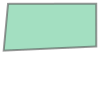

In [26]:
poly_list[0]

In [21]:
len(poly_list)

16

In [27]:
geo_poly = points(poly_list[0])

In [28]:
geo_poly

[(-81.218376301, 26.1663754840001),
 (-81.218523916, 26.1663752600001),
 (-81.218531151, 26.16629699),
 (-81.218376168, 26.166303885),
 (-81.218376301, 26.1663754840001)]

In [24]:
len(geo_poly)

5

In [ ]:
for i in range(0,len(poly_list)):

    if poly_list[i].geom_type == 'MultiPolygon':

        for j in range(0, len(poly_list[i])):

            geo_poly = points(poly_list[i][j])

            for k in range(0, len(geo_poly)):

                fire_lon = geo_poly[k][0]
                fire_lat = geo_poly[k][1]

                dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

                if dist <= 100:
                    geo_center = [fire_lon, fire_lat]
                    break

            if len(geo_center) > 0:
                break

        if len(geo_center) > 0:
            break

    else:

        geo_poly = points(poly_list[i])

        for j in range(0, len(geo_poly)):

            fire_lon = geo_poly[j][0]
            fire_lat = geo_poly[j][1]

            dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

            if dist <= 100:
                geo_center = [fire_lon, fire_lat]
                break
                
        if dist <= 100:
            geo_center = [fire_lon, fire_lat]
            break

    if len(geo_center) > 0:
        break

In [13]:
def fire_map():

	geo_center = []
	add_loc = []

	address = "Berkeley, CA"
# 	if request.method == "POST":
# 		address = str(request.form["address"])
	
	add_lat, add_lon = get_lat_loc(address)
	
	geo_center = active_fire(add_lat, add_lon)

	# for i in range(0, len(geo_center)):
	geo_lat = geo_center[1]
	geo_lon = geo_center[0]
	crs = convert_point(geo_lat, geo_lon)

	map_output = read_csv()

In [ ]:
fire_map()

In [ ]:
# set variables
lat_geo = []
lon_geo = []
geo_center = []

url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
# geo_data = requests.get(url).json()	
geo_data = gpd.read_file(url)

poly_list = geo_data.geometry

for i in range(0,len(poly_list)):

    if len(geo_center) > 0:
        break

    if poly_list[i].geom_type == 'MultiPolygon':

        for j in range(0, len(poly_list[i])):

            geo_poly = points(poly_list[i][j])

            for k in range(0, len(geo_poly)):

                fire_lon = geo_poly[k][0]
                fire_lat = geo_poly[k][1]

                dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

                if dist <= 100:
                    geo_center = [fire_lon, fire_lat]
                    break

            if len(geo_center) > 0:
                break

        if len(geo_center) > 0:
            break

    else:

        geo_poly = points(poly_list[i])

        for j in range(0, len(geo_poly)):

            fire_lon = geo_poly[j][0]
            fire_lat = geo_poly[j][1]

            dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

            if dist <= 100:
                geo_center = [fire_lon, fire_lat]
                break

        if len(geo_center) > 0:
            break

    if len(geo_center) > 0:
        break

return geo_center, geo_poly